In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [ ]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import traffic collisions data
- Traffic Collisions https://opendata.arcgis.com/api/v3/datasets/2a36d61277a84c3eb9d0beebef4c023d_0/downloads/data?format=csv&spatialRefId=3857

In [ ]:
collision_df = pd.read_csv('./raw_data/Traffic_Collisions.csv')
collision_df

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Longitude,Latitude,ObjectId2
0,0.000000e+00,0.000000e+00,1,GO-20141001,2014/02/07 05:00:00+00,February,Friday,2014,16,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,1
1,0.000000e+00,0.000000e+00,2,GO-20141225593,2014/01/02 05:00:00+00,January,Thursday,2014,3,NSA,NSA,NSA,0,NO,YES,NO,0.000000,0.000000,2
2,0.000000e+00,0.000000e+00,3,GO-20141260499,2014/01/01 05:00:00+00,January,Wednesday,2014,2,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,3
3,0.000000e+00,0.000000e+00,4,GO-20141260663,2014/01/01 05:00:00+00,January,Wednesday,2014,3,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,4
4,0.000000e+00,0.000000e+00,5,GO-20141261162,2014/01/01 05:00:00+00,January,Wednesday,2014,5,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499533,-8.865398e+06,5.426816e+06,499212,GO-20178006796,2017/02/14 05:00:00+00,February,Tuesday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499534
499534,-8.865398e+06,5.426816e+06,499213,GO-20178007507,2017/02/18 05:00:00+00,February,Saturday,2017,13,NSA,NSA,NSA,0,NO,YES,NO,-79.639225,43.749873,499535
499535,-8.865398e+06,5.426816e+06,499214,GO-20178008123,2017/02/22 05:00:00+00,February,Wednesday,2017,22,D23,1,West Humber-Clairville (1),0,NO,NO,YES,-79.639225,43.749873,499536
499536,-8.865398e+06,5.426816e+06,499215,GO-20178014940,2017/04/07 04:00:00+00,April,Friday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499537


In [ ]:
collision_df.shape

(499538, 19)

In [ ]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Extract Hood_ID from neighbourhood

In [ ]:
collision_df[['Neighbourhood', 'Hood_ID']] = collision_df['Neighbourhood'].str.split('(', 1, expand=True)
collision_df['Hood_ID'] = collision_df['Hood_ID'].str.split(')', 1, expand=True).iloc[:,0].fillna('NSA')

In [ ]:
# check that every NSA in Hood_ID is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['Hood_ID'] == "NSA"]['Neighbourhood'].unique()

array(['NSA'], dtype=object)

In [ ]:
# should only show "NSA" as the only unique entry
collision_df[collision_df['Neighbourhood'] == "NSA"]['Hood_ID'].unique()

array(['NSA'], dtype=object)

In [ ]:
collision_df.drop(columns=['Atom'], inplace=True)

In [ ]:
# keep the format consistent with mci_df
pd.concat([collision_df.iloc[0,:], mci_df.iloc[0,:]], axis=1)

,0,0
X,0.0,-8854229.185019
Y,0.0,5425760.377233
OBJECTID,1,NaN
EventUniqueId,GO-20141001,NaN
OccurrenceDate,2014/02/07 05:00:00+00,NaN
Month,February,NaN
Day_of_Week,Friday,NaN
Year,2014,NaN
Hour,16,NaN
Division,NSA,D31


In [ ]:
collision_df.rename(columns={'Longitude': 'Long', 
                             'Latitude': 'Lat',
                             'EventUniqueId': 'event_unique_id',
                             'OccurrenceDate': 'occurrencedate',
                             'Month': 'occurrencemonth',
                             'Day_of_Week': 'occurrencedayofweek',
                             'Year': 'occurrenceyear',
                             'Hour': 'occurrencehour',
                             'OBJECTID': 'ObjectId'}, inplace=True)

In [ ]:
collision_df['occurrencedate'] = pd.to_datetime(collision_df['occurrencedate'])

In [ ]:
collision_df['occurrenceday'] = collision_df['occurrencedate'].dt.day.astype(float)
collision_df['occurrencedayofyear'] = collision_df['occurrencedate'].dt.dayofyear.astype(float)

## Checking for inconsistencies

In [ ]:
# is the year, month, day etc. consistent with the date column?
print(sum(collision_df.occurrencedate.dt.year != collision_df.occurrenceyear))
print(sum(collision_df.occurrencedate.dt.strftime("%B") != collision_df.occurrencemonth))
print(sum(collision_df.occurrencedate.dt.day.astype(float) != collision_df.occurrenceday))
print(sum(collision_df.occurrencedate.dt.dayofyear.astype(float) != collision_df.occurrencedayofyear))
print(sum(collision_df.occurrencedate.dt.strftime("%A") != collision_df.occurrencedayofweek))
print(sum(collision_df.occurrencedate.dt.hour != collision_df.occurrencehour))

0
0
0
0
0
495996


In [ ]:
# occurencehour looks incorrect
print(collision_df[collision_df.occurrencedate.dt.hour != collision_df.occurrencehour].occurrencedate.dt.hour)
collision_df.loc[collision_df.occurrencedate.dt.hour != collision_df.occurrencehour, ['occurrencedate', 'occurrencehour']]

0         5
1         5
2         5
3         5
6         5
         ..
499533    5
499534    5
499535    5
499536    4
499537    4
Name: occurrencedate, Length: 495996, dtype: int64


,occurrencedate,occurrencehour
0,2014-02-07 05:00:00+00:00,16
1,2014-01-02 05:00:00+00:00,3
2,2014-01-01 05:00:00+00:00,2
3,2014-01-01 05:00:00+00:00,3
6,2014-01-01 05:00:00+00:00,8
...,...,...
499533,2017-02-14 05:00:00+00:00,14
499534,2017-02-18 05:00:00+00:00,13
499535,2017-02-22 05:00:00+00:00,22
499536,2017-04-07 04:00:00+00:00,14


In [ ]:
collision_df.occurrencedate.dt.hour.describe()

count    499538.000000
mean          4.371768
std           0.483277
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: occurrencedate, dtype: float64

In [ ]:
collision_df.occurrencehour.describe()

count    499538.000000
mean         13.474358
std           4.921921
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: occurrencehour, dtype: float64

<AxesSubplot:xlabel='occurrencehour'>

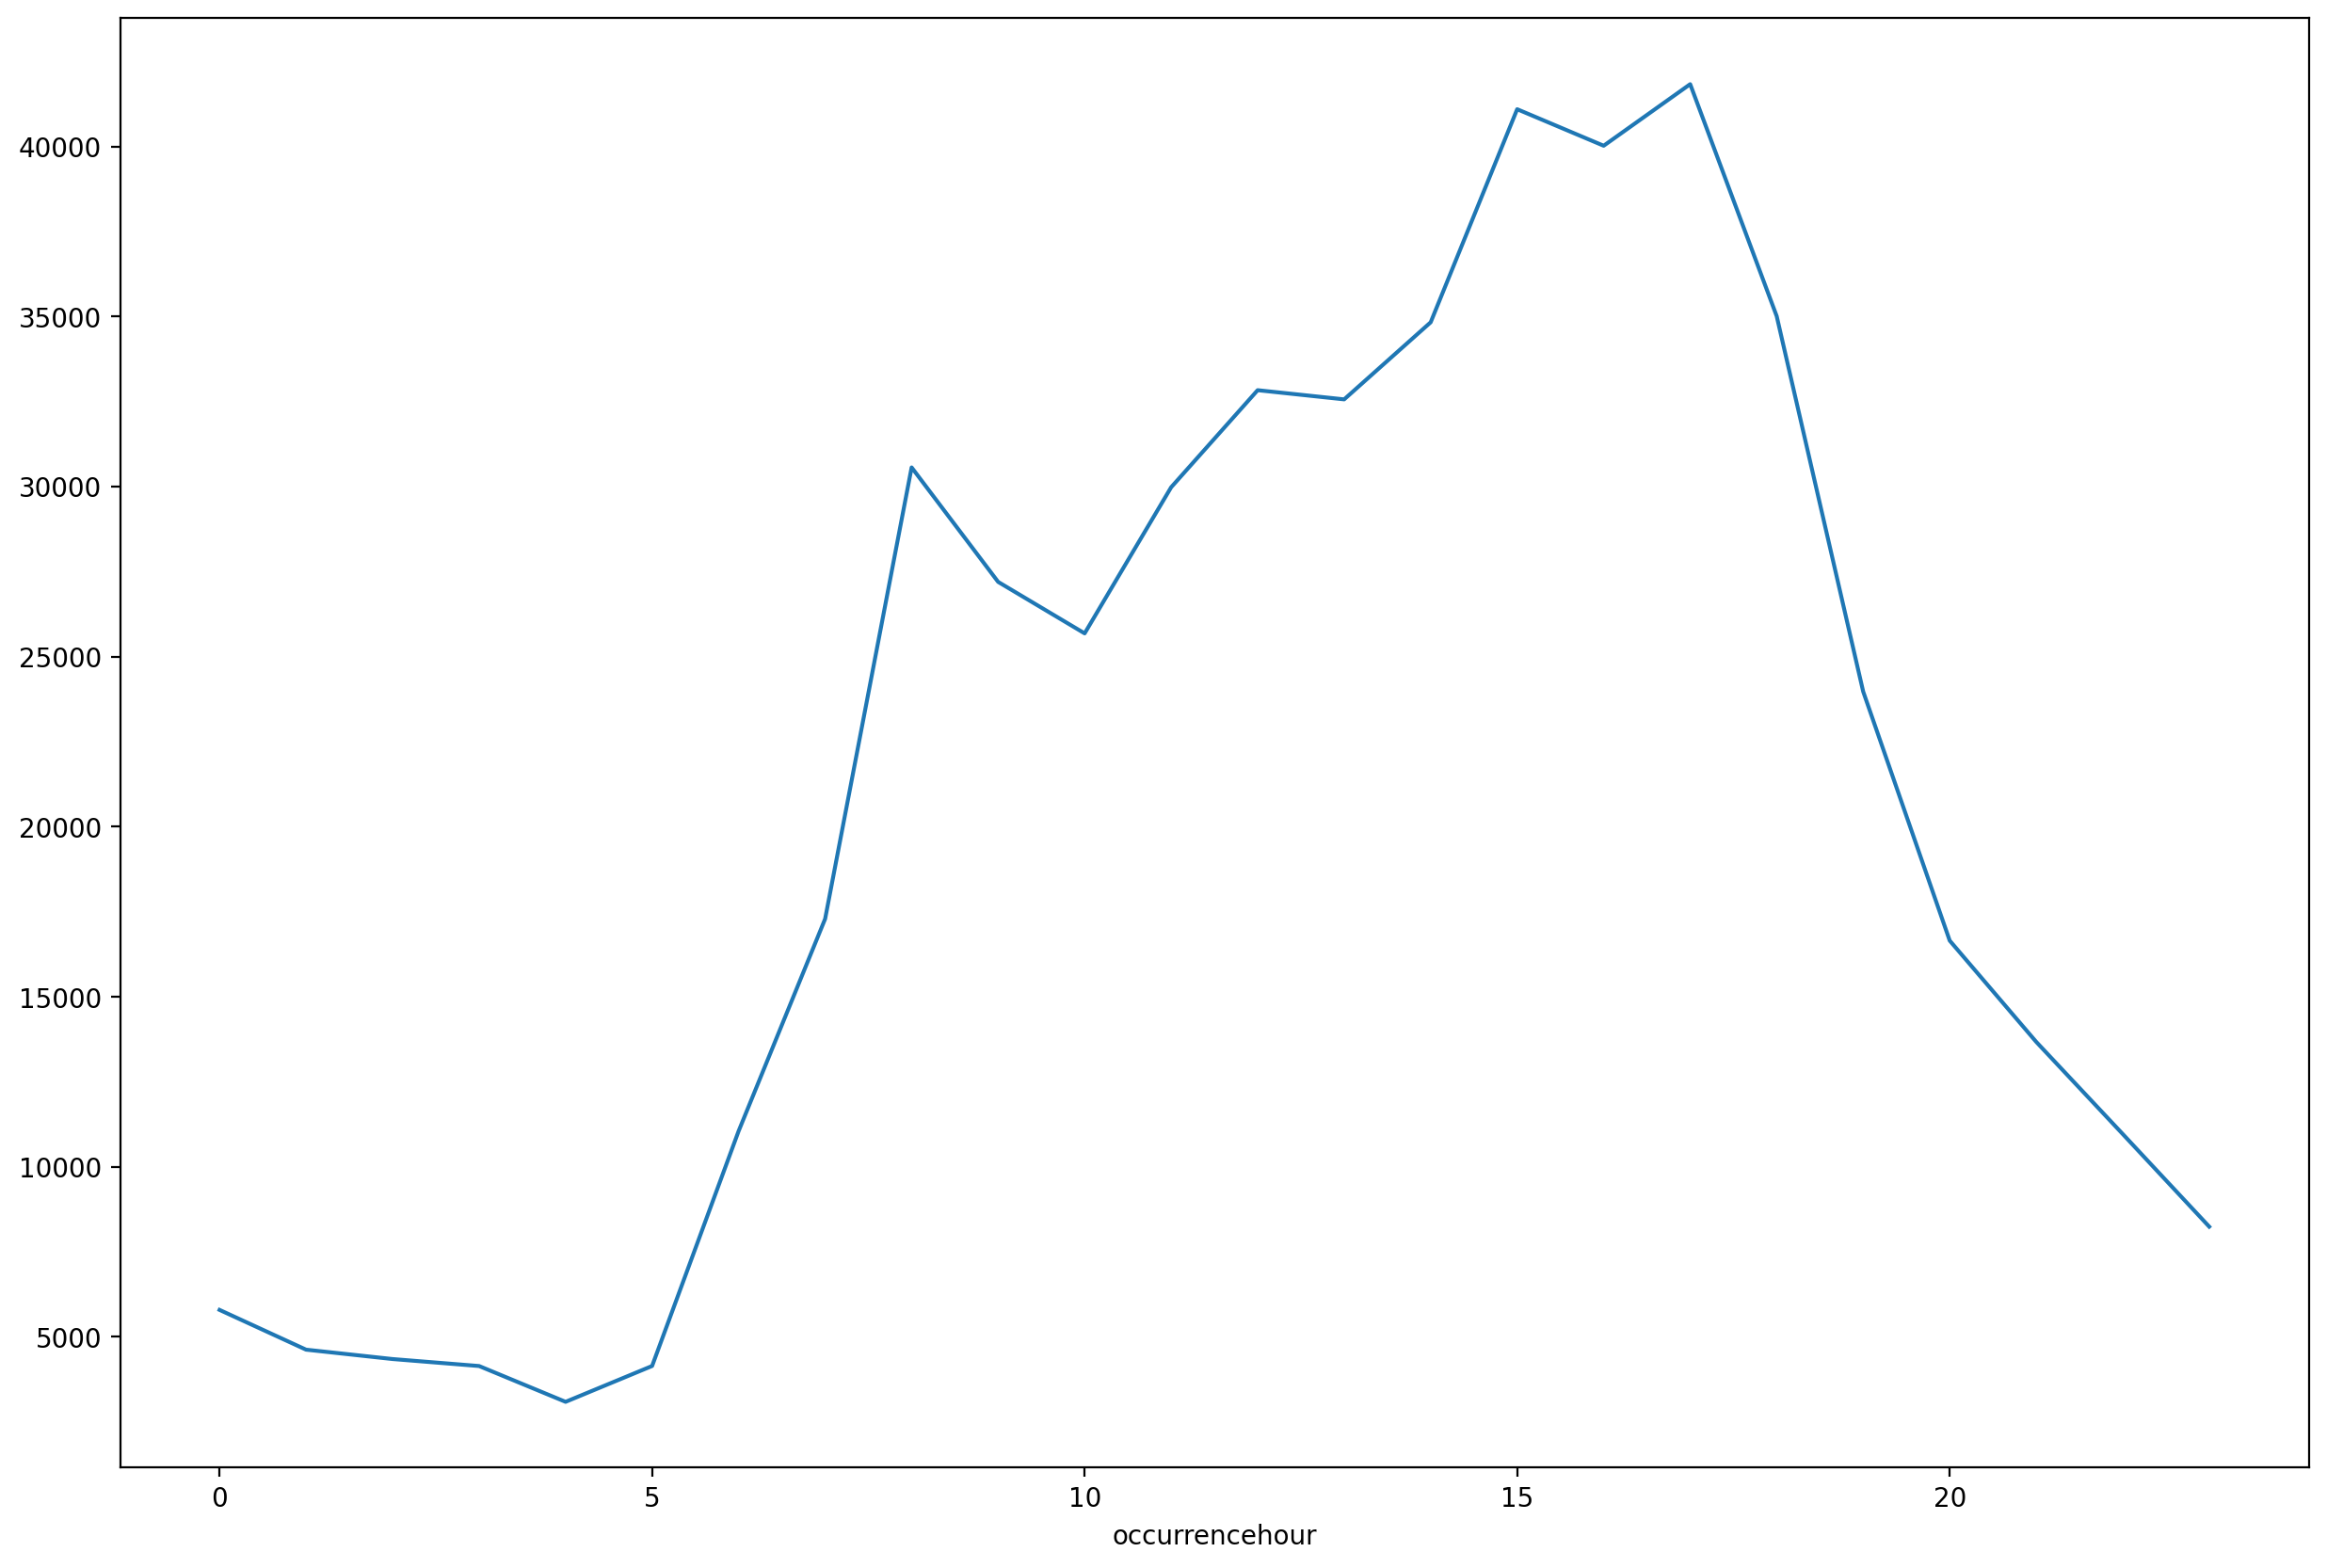

In [ ]:
# makes sense that most of the traffic collisions happen in the afternoon when roads are most busy
collision_df.groupby(['occurrencehour']).size().plot()

In [ ]:
collision_df['occurrencedate'][0]

Timestamp('2014-02-07 05:00:00+0000', tz='UTC')

In [ ]:
collision_df['occurrencedate'][0].replace(hour=int(collision_df['occurrencehour'][0]), 
                                          tzinfo=dt.timezone(dt.timedelta(hours=-4))) # Toronto GMT-4

Timestamp('2014-02-07 16:00:00-0400', tz='UTC-04:00')

In [ ]:
dates = []
for date, hour in zip(collision_df.occurrencedate, collision_df.occurrencehour):
    dates.append(date.replace(hour=int(hour), tzinfo=dt.timezone(dt.timedelta(hours=-4)))) # Toronto GMT-4

In [ ]:
collision_df['occurrencedate'] = dates

## Impute missing long and lat

In [ ]:
collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0), ["Neighbourhood"]].value_counts()

Neighbourhood                
NSA                              69252
Wexford/Maryvale                    64
West Hill                           26
Kennedy Park                        15
Yorkdale-Glen Park                  13
Hillcrest Village                   12
LAmoreaux                           11
Glenfield-Jane Heights               8
Clairlea-Birchmount                  8
York University Heights              7
Bendale                              7
Highland Creek                       5
Agincourt South-Malvern West         5
Black Creek                          5
Islington-City Centre West           4
Bay Street Corridor                  3
Bayview Woods-Steeles                3
Bathurst Manor                       2
Church-Yonge Corridor                2
Westminster-Branson                  2
West Humber-Clairville               2
Pelmo Park-Humberlea                 2
St.Andrew-Windfields                 1
Woburn                               1
Bedford Park-Nortown              

In [ ]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['Long'] == 0) & (collision_df['Lat'] == 0) & (collision_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [ ]:
missing_location = collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0)].index
collision_df.loc[missing_location]

,X,Y,ObjectId,event_unique_id,occurrencedate,occurrencemonth,occurrencedayofweek,occurrenceyear,occurrencehour,Division,Hood_ID,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID,occurrenceday,occurrencedayofyear
0,0.0,0.0,278,GO-20141591056,2014-02-24 17:00:00-04:00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,NO,YES,NO,0.0,0.0,178,40,24.0,55.0
1,0.0,0.0,1246,GO-20143120578,2014-10-17 09:00:00-04:00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,NO,NO,YES,0.0,0.0,1046,25,17.0,290.0
2,0.0,0.0,21564,GO-20168056919,2016-12-17 09:00:00-04:00,December,Saturday,2016,9,D31,27,York University Heights,0,NO,NO,YES,0.0,0.0,21094,27,17.0,352.0
3,0.0,0.0,21709,GO-20168059092,2016-12-27 18:00:00-04:00,December,Tuesday,2016,18,D32,31,Yorkdale-Glen Park,0,NO,YES,NO,0.0,0.0,21162,31,27.0,362.0
4,0.0,0.0,21277,GO-20168053844,2016-11-30 18:00:00-04:00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,NO,NO,YES,0.0,0.0,21340,48,30.0,335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.0,0.0,69463,GO-20198030463,2019-05-20 08:00:00-04:00,May,Monday,2019,8,D43,103,Lawrence Park South,0,YES,NO,NO,0.0,0.0,69919,103,20.0,140.0
714,0.0,0.0,69464,GO-20198076663,2019-12-21 12:00:00-04:00,December,Saturday,2019,12,D42,1,West Humber-Clairville,0,NO,NO,YES,0.0,0.0,69921,1,21.0,355.0
715,0.0,0.0,69465,GO-20201700319,2020-09-08 15:00:00-04:00,September,Tuesday,2020,15,D33,45,Parkwoods-Donalda,0,NO,YES,YES,0.0,0.0,69923,45,8.0,252.0
716,0.0,0.0,69466,GO-20208029200,2020-09-30 15:00:00-04:00,September,Wednesday,2020,15,D32,105,Lawrence Park North,0,NO,NO,YES,0.0,0.0,69925,105,30.0,274.0


In [ ]:
missing_count = collision_df.loc[missing_location].groupby('Hood_ID').size()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'Hood_ID', 'Hood_ID':'count'})
missing_count

ValueError: Grouper for 'Hood_ID' not 1-dimensional

In [ ]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['Hood_ID']), axis=1)

86 points generated but only include the 64 points within the neighborhood
49 points generated but only include the 26 points within the neighborhood
34 points generated but only include the 15 points within the neighborhood
15 points generated but only include the 13 points within the neighborhood
17 points generated but only include the 12 points within the neighborhood
29 points generated but only include the 11 points within the neighborhood
10 points generated but only include the 8 points within the neighborhood
19 points generated but only include the 8 points within the neighborhood
12 points generated but only include the 7 points within the neighborhood
7 points generated but only include the 7 points within the neighborhood
10 points generated but only include the 5 points within the neighborhood
10 points generated but only include the 5 points within the neighborhood
7 points generated but only include the 5 points within the neighborhood
10 points generated but only inclu

In [ ]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

,Hood_ID,count,Long,Lat,len
0,119,64,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",64
1,136,26,"[-79.19911824880309, -79.18040350946745, -79.1...","[43.75765197946631, 43.76546946821289, 43.7572...",26
2,124,15,"[-79.26654982146835, -79.27463062049003, -79.2...","[43.72232249578001, 43.7224000798009, 43.71780...",15
3,31,13,"[-79.45996226267624, -79.46065952752981, -79.4...","[43.707040006978474, 43.71897347621641, 43.705...",13
4,48,12,"[-79.3520875268021, -79.33868359752705, -79.36...","[43.80780466875634, 43.80490053510152, 43.8091...",12
5,117,11,"[-79.30228548159286, -79.29101438573844, -79.3...","[43.79210334082548, 43.796763995859656, 43.796...",11
6,25,8,"[-79.51354369472986, -79.51079945917418, -79.5...","[43.74301390592894, 43.756067443593345, 43.739...",8
7,120,8,"[-79.29825934015967, -79.28250707547197, -79.2...","[43.717965362775196, 43.7212468235057, 43.7092...",8
8,27,7,"[-79.49825254767276, -79.48530259746411, -79.4...","[43.76390670967839, 43.7606371871618, 43.76592...",7
9,127,7,"[-79.25473825213193, -79.26135086018229, -79.2...","[43.77002794299879, 43.77322670528096, 43.7432...",7


In [ ]:
# impute the missing long and lat values
for i in missing_count["Hood_ID"].unique():    
    index = (collision_df['Hood_ID'] == str(i)) & ((collision_df['Long'] == 0) | (mci_df['Lat'] == 0))
    collision_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(collision_df.loc[index, 'Long'] == 0, 
                                                                      missing_count[missing_count['Hood_ID'] == str(i)]['Long'].iloc[0],
                                                                      collision_df.loc[index, 'Long']),
                                                             np.where(collision_df.loc[index, 'Lat'] == 0, 
                                                                      missing_count[missing_count['Hood_ID'] == str(i)]['Lat'].iloc[0],
                                                                      collision_df.loc[index, 'Lat'])]).T.values

In [ ]:
# check missing long and lat values are now imputed
collision_df.loc[missing_location]

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID
0,0.0,0.0,278,GO-20141591056,2014/02/24 05:00:00+00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,NO,YES,NO,-79.402034,43.748097,178,40
1,0.0,0.0,1246,GO-20143120578,2014/10/17 04:00:00+00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,NO,NO,YES,-79.513544,43.743014,1046,25
2,0.0,0.0,21564,GO-20168056919,2016/12/17 05:00:00+00,December,Saturday,2016,9,D31,27,York University Heights,0,NO,NO,YES,-79.498253,43.763907,21094,27
3,0.0,0.0,21709,GO-20168059092,2016/12/27 05:00:00+00,December,Tuesday,2016,18,D32,31,Yorkdale-Glen Park,0,NO,YES,NO,-79.459962,43.707040,21162,31
4,0.0,0.0,21277,GO-20168053844,2016/11/30 05:00:00+00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,NO,NO,YES,-79.352088,43.807805,21340,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.0,0.0,69463,GO-20198030463,2019/05/20 04:00:00+00,May,Monday,2019,8,D43,103,Lawrence Park South,0,YES,NO,NO,-79.412967,43.714967,69919,103
714,0.0,0.0,69464,GO-20198076663,2019/12/21 05:00:00+00,December,Saturday,2019,12,D42,1,West Humber-Clairville,0,NO,NO,YES,-79.616253,43.752839,69921,1
715,0.0,0.0,69465,GO-20201700319,2020/09/08 04:00:00+00,September,Tuesday,2020,15,D33,45,Parkwoods-Donalda,0,NO,YES,YES,-79.342754,43.761909,69923,45
716,0.0,0.0,69466,GO-20208029200,2020/09/30 04:00:00+00,September,Wednesday,2020,15,D32,105,Lawrence Park North,0,NO,NO,YES,-79.415767,43.732380,69925,105


### Add geometry points

In [ ]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [ ]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

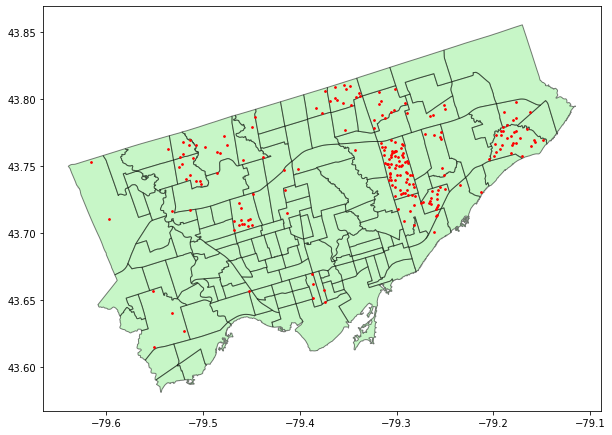

In [ ]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

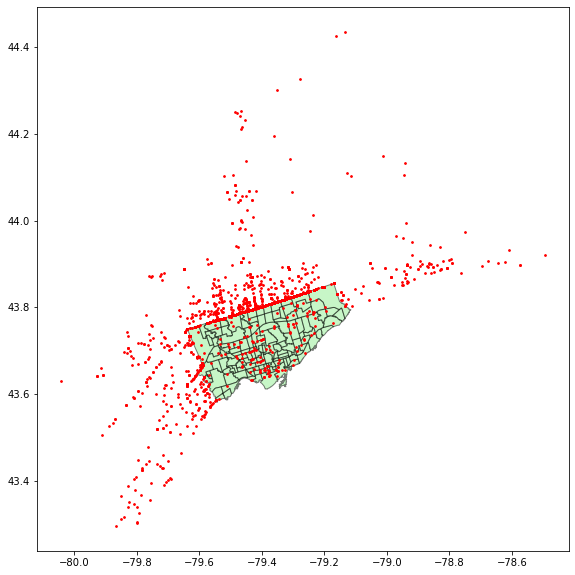

In [ ]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [ ]:
# get the points contained within the neighbourhood
NSA_within_neighbourhood = gpd.sjoin(collision_point[collision_point['Neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighbourhood.index, ['Hood_ID', 'Neighbourhood']] = NSA_within_neighbourhood[['Hood_ID_right', 'Neighbourhood_right']].values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



<AxesSubplot:>

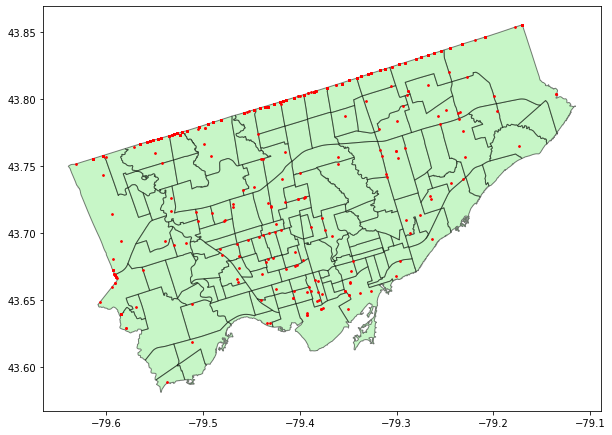

In [ ]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

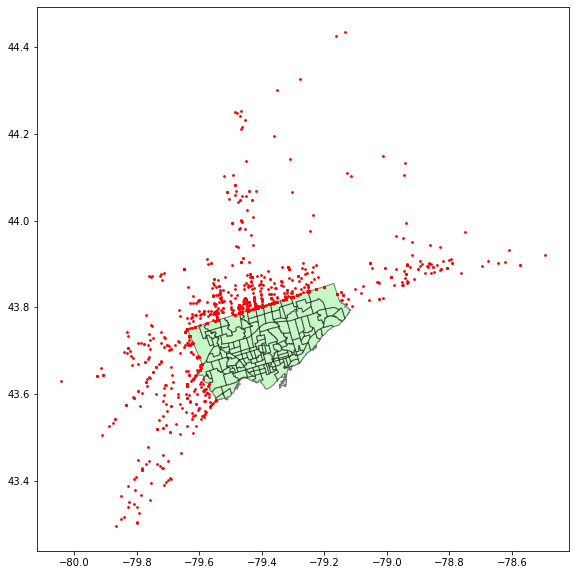

In [ ]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

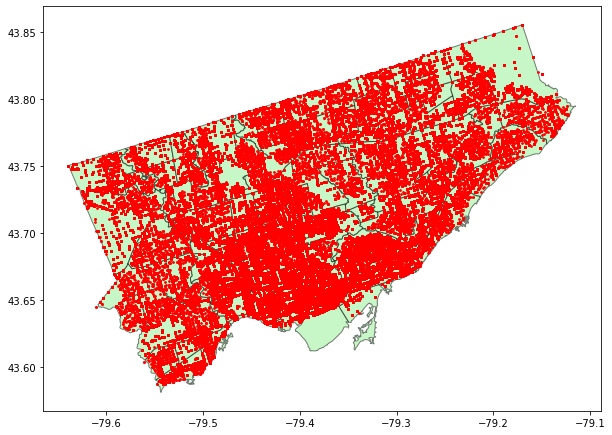

In [ ]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [ ]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.to_csv('./clean_data/collision_point.csv', index=False)